# Building a Security Graph Application on Amazon Neptune

This notebook shows how Amazon Neptune can be used to build a security graph for a cloud security posture solution. It includes a data model based on a realistic AWS account configuration that connects IAM policies, IAM roles, networking resources, compute resources, and security groups into a system that enables users to identify potentially insecure resources and identify like remediation candidates.  


* [Background](#Background)
* [Getting Started](#Getting-Started)
* [Insecure Resources](#Identifying-insecure-resources)
* [Assessing the Impact](#Assessing-the-impact)
* [Conclusion](#Conclusion)
* [What's Next?](#What's-Next?)

## Background

Modern security profiles take a layered security approach. No individual layer stops all threats, but together they mitigate a wide variety of threats and provide redundancy should any layer fail. It is important to realize that these layers are often loosely coupled and individually managed. By storing this information in a security graph, the relationships between those layers can be modeled and analyzed to provide a holistic view of the security profile and to find gaps across the layers.

A security graph connects resources within a network: entities such as policies, roles and resources. By relating these entities together, we improve our chances to detect, prevent, and remediate security risk that violate compliance and enable better enforcement of security requirements. With Amazon Neptune, we can connect entities together in such a way that we can query it whenever new resources are created in the system. Using queries that find patterns in our data that we know to be indicative of security risks, we can evaluate the scope and impact of these risks, and thereby determine whether constellations of data in the security graph represent a real or potential security issue.

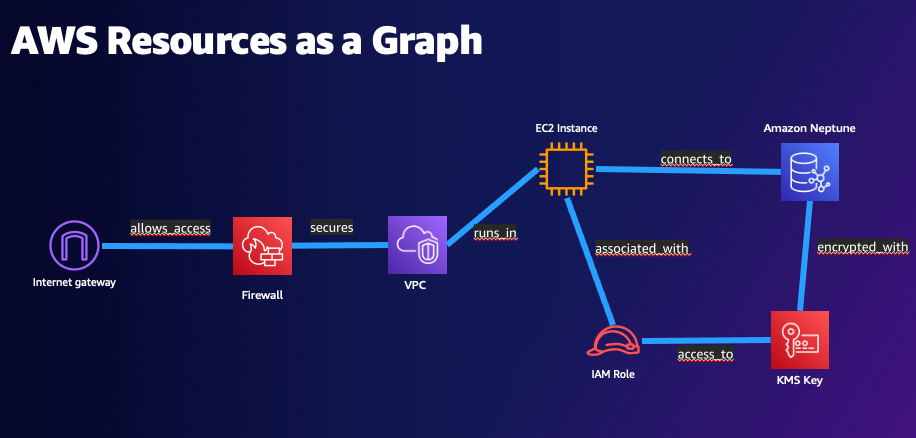

The examples in this use case show how we can identify insecure resources and instances, and then how to identify potential areas for remediation of these issues.
  
Most of the queries in this notebook are graph local queries. A graph local query takes as its starting point an individual entity - an IAM policy, or IAM role, for example - and from there explores the neighboring parts of the graph to compute a result or discover a local constellation of connected data. Security graph solutions use graph local queries when resources are created or modified, or new resources are submitted to the system, to identify potentially misconfigured or insecure resources.



## Getting Started

In this section, we'll load the security graph and set some visualization options. We'll then use some graph queries to inspect the data model used throughout the solution.


## Load data

The cell below loads the example security graph into your Neptune cluster. When you run the cell, it will automatically run the %seed command which select a Data Model (Property_Graph) and a data set (security-graph) and begin the load. The graph takes about 1 minute to load.


In [ ]:
%seed --dataset security-graph --model Property_Graph --run

### Set visualization options
The command below configures the visualization to use specific colors and icons for the different parts of the data model.

In [ ]:
%%graph_notebook_vis_options
{
  "groups": {    
    "iam:role": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/Security%2C+Identity%2C+%26+Compliance/AWS-Identity-and-Access-Management-IAM_Role_light-bg%404x.png"},
    "iam:instance-profile": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/Security%2C+Identity%2C+%26+Compliance/AWS-Identity-and-Access-Management_IAM_light-bg%404x.png"},
    "iam:policy": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/Security%2C+Identity%2C+%26+Compliance/AWS-Identity-and-Access-Management-IAM_Temporary-Security-Credential_light-bg%404x.png"},
    "ec2:security-group": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/Security%2C+Identity%2C+%26+Compliance/Security-Identity-and-Compliance_light-bg%404x.png"},
    "s3:bucket": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/Storage/Amazon-Simple-Storage-Service-S3%404x.png"},
    "ec2:vpc": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/_Group+Icons/Virtual-private-cloud-VPC_light-bg%404x.png"},
    "ec2:network-interface": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/Networking+%26+Content+Delivery/Amazon-VPC_Elastic-Network-Interface_light-bg%404x.png"},
    "ec2:vpc-endpoint": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/Networking+%26+Content+Delivery/Amazon-VPC_Endpoints_light-bg%404x.png"},
    "ec2:route-table": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/Networking+%26+Content+Delivery/Amazon-VPC_Router_light-bg%404x.png"},
    "rds:db": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/Database/Amazon-RDS_light-bg%404x.png"},
    "ec2:subnet": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/_Group+Icons/VPC-subnet-private_light-bg%404x.png"},
    "kms:key": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/Security%2C+Identity%2C+%26+Compliance/AWS-Key-Management-Service_light-bg%404x.png"},
    "ec2:internet-gateway": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/Networking+%26+Content+Delivery/Amazon-VPC_Internet-Gateway_light-bg%404x.png"},
    "ec2:instance": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/Compute/Amazon-EC2_light-bg%404x.png"},
      "ec2:volume": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/Storage/Amazon-Elastic-Block-Store-EBS_light-bg@4x.png"},
          "image": {"shape": "image", 
               "image":"https://aws-neptune-customer-samples.s3.amazonaws.com/getting-started-with-altimeter/icons/PNG+Light/Compute/Amazon-EC2-Container-Registry_Image_light-bg%404x.png"},
    "tag": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf02c",
        "color": "black"
      }
    }
  }
}

### Data model

The security graph included in this example model was generated using Altimeter, (https://tableau.github.io/altimeter/) which is an open-source project from Tableau that can be used to scan AWS system resources and store that into Amazon Neptune, as shown in this blog post (https://aws.amazon.com/blogs/database/graph-your-aws-resources-with-amazon-neptune/).  While Altimeter can store data as both RDF or Labeled Property Graph, we have used the Labeled Property Graph model for this notebook.  

With this tool, the data is modeled for an AWS account as a set of resources, such as ec2:instance, ec2:vpc, iam:role, iam:policy, etc. which are connected via edges such as resource_link, transient_resource_link, tagged, etc. to represent the rich interconnection of resources within a cloud environment.


The following query shows a single EC2 instance and its associated resources. After running the query, click the Graph tab to see a visualization of the results.


In [ ]:
%%gremlin

g.V(
  'arn:aws:ec2:us-east-2:555555555555:instance/i-0f8cb0bc2ef8111f9_20220505/1651782433/0d5ef76c-b2c0-4063-8c54-a35a1bd0a364').
  bothE().
  otherV().
  path().by(elementMap())

## Identifying insecure or unused resources

One common use for security graphs is cloud security posture management, which enables users to look identify gaps in security, misconfigurations, or other compliance risks.  Identification of these types of gaps often begins by searching for any sort of unused or insecure resource within your infrastructure.  Identifying these resources is a critical first step to helping plan, predict, and mitigate any sort of potential risk in your infrastructure.


### Unused IAM Policies?

A common place to start looking for risks in your infrastructure is to look for unused resources within your infrastructure.  Running the query below will find all resources within the graph that are not connected to any other resources.

In [ ]:
%%gremlin
g.V().
  where(bothE().count().is(0)).
  groupCount().by(label).
  unfold().
  order().by(values, desc)

Often the next step is to filter down these resources to look at specific types of resources instead of all resource types.  Running the query below will find all the `iam:policy` nodes that are not connected to any resources.

In [ ]:
%%gremlin
g.V().hasLabel('iam:policy').where(bothE().count().is(0)).elementMap()

### Do I have any insecure policies? 
Beyond focusing on unused resources, security graphs are often used to aid in identifying potentially insecure resources that may violate security policies or pose some level of unacceptable risk within an account's infrastructure.  

The following query shows all the `iam:policy` nodes that are either the built-in `AdministratorAccess` policy or contain wildcards (`*`) within their policy text.

In [ ]:
%%gremlin
g.V().
  hasLabel('iam:policy').
  where(
    has('name', 'AdministratorAccess').
    or().
    has('default_version_policy_document_text', containing('*'))).
  both('resource_link').
  hasLabel('iam:role').
  path().by(elementMap())

As we see, our security graph identifies two policies that meet these criteria.  However, having a potentially insecure policy is only part of the equation, it also matters where/how these policies are used.

### What roles are using these policies?

Running the following query finds all the IAM roles that are using the potentially insecure policies we identified.

In [ ]:
%%gremlin
g.V().
  hasLabel('iam:policy').
  where(
    has('name', 'AdministratorAccess').
    or().
    has('default_version_policy_document_text', containing('*'))).
  both('resource_link').
  hasLabel('iam:role').
  path().by(elementMap())

### What resources use those roles?

Let's take this one step further and run the query below to find out what resources are using these roles.

In [ ]:
%%gremlin
g.V().
  hasLabel('iam:policy').
  where(
    has('name', 'AdministratorAccess').
    or().
    has('default_version_policy_document_text', containing('*'))).
  bothE('resource_link').
  otherV().
  hasLabel('iam:role').
  repeat(
    bothE('resource_link', 'transient_resource_link').
    otherV().
    simplePath()).
    times(2).
  path().by(elementMap())

### What connects to those resources?

Now that we know that we have resources that are using these roles, let's run the following query to examine the blast radius of these roles by examining the resources that are connected to these potentially insecure resources.

In [ ]:
%%gremlin
g.V().
  hasLabel('iam:policy').
  where(
    has('name', 'AdministratorAccess').
    or().
    has('default_version_policy_document_text', containing('*'))).
  bothE('resource_link').
  otherV().
  hasLabel('iam:role').emit().
  repeat(
    bothE('resource_link', 'transient_resource_link').
    otherV().
    simplePath()).
    times(6).
  path().by(elementMap())

## Assessing the Impact

While identification of security gaps within your infrastructure is a critical part of any security graph, it is not the end goal. Once we have identified potentially insecure, the next step is to assess the impact of these risks and mitigate any sort of potential risk in your infrastructure.  One common way to approach this is to look at the impacted resources and see what sort of information they may contain or access.

### Are there any EC2 instances or databases that are potentially insecure?

Run the following query to find out if our account has any potentially insecure EC2 or RDS instances.

In [ ]:
%%gremlin
g.V().
  hasLabel('iam:policy').
  where(
    has('name', 'AdministratorAccess').
    or().
    has('default_version_policy_document_text', containing('*'))).
  bothE('resource_link').
  otherV().
  hasLabel('iam:role').emit().
  repeat(
    bothE('resource_link', 'transient_resource_link').
    otherV().
    simplePath()).
    times(2).
  hasLabel(within('ec2:instance', 'rds:db')).
  path().by(elementMap())

As we see, our account does contain two compute resources, both EC2 instances that are potentially insecure.  However, security is a multi-layered problem, so let's take a look at if and how these instances may be accessible to bad actors.

### Are these EC2 instances exposed to the internet?

Running the following query will show if any of these potentially insecure EC2 instances are exposed to the internet.

In [ ]:
%%gremlin
g.V().
  hasLabel('iam:policy').
  where(
    has('name', 'AdministratorAccess').
    or().
    has('default_version_policy_document_text', containing('*'))).
  bothE('resource_link').
  otherV().
  hasLabel('iam:role').emit().
  repeat(
    bothE('resource_link', 'transient_resource_link').
    otherV().
    simplePath()).
    times(2).
  hasLabel('ec2:instance').
  has('public_ip_address').
  path().by(elementMap())

### How are they exposed?

We see that both of these instances are publicly accessible from the internet, let's look at the associated security groups to see where we might want to start remedying this risk.

In [ ]:
%%gremlin
g.V().
  hasLabel('iam:policy').
  where(
    has('name', 'AdministratorAccess').
    or().
    has('default_version_policy_document_text', containing('*'))).
  bothE('resource_link').
  otherV().
  hasLabel('iam:role').emit().
  repeat(
    bothE('resource_link', 'transient_resource_link').
    otherV().
    simplePath()).
    times(2).
  hasLabel('ec2:instance').
  has('public_ip_address').
  both('resource_link', 'transient_resource_link').
  simplePath().
  hasLabel('ec2:security-group').
  path().by(elementMap())

## Conclusion

This notebook has shown how you can use Amazon Neptune to create a security graph as part of a cloud posture management solution. We've used a real-world AWS account graph to locate unused or potentially insecure resources within our infrastructure.  We then explored the connected resources to see the extent of the potential risk caused by these resources.  Once we had a feel for the potential risk, we looked at the potential exploitation paths a bad actor may exploit and identified areas to look for a remedy.  

## What's Next

The examples in this notebook show how to develop a security graph data model and accompanying queries. To build a security graph solution that incorporates Neptune, we recommend the following resources:

* [Amazon Neptune Security Graphs](https://aws.amazon.com/neptune/security-graphs-on-aws/) - Build a security graph with Amazon Neptune to efficiently manage the security of your IT infrastructure.

* [Getting Started with Amazon Neptune](https://pages.awscloud.com/AWS-Learning-Path-Getting-Started-with-Amazon-Neptune_2020_LP_0009-DAT.html) is a video-based learning path that shows you how to create and connect to a Neptune database, choose a data model and query language, author and tune graph queries, and integrate Neptune with other Amazon Web Services.
* [Graph your AWS resources with Amazon Neptune](https://aws.amazon.com/blogs/database/graph-your-aws-resources-with-amazon-neptune/) is a blog post that guides you through using the open-source software Altimeter to generate a security graph of your AWS Account.
* Before you begin designing your database, consult the [Amazon Web Services Reference Architectures for Using Graph Databases](https://github.com/aws-samples/aws-dbs-refarch-graph/) GitHub repo, where you can browse examples of reference deployment architectures, and learn more about building a graph data model and choosing a query language.
* For links to documentation, blog posts, videos, and code repositories with samples and tools, see the [Amazon Neptune developer resources](https://aws.amazon.com/neptune/developer-resources/).